In [1]:
%pylab inline 


Populating the interactive namespace from numpy and matplotlib


In [2]:
import gym
import sys
sys.path.append('/home/peter/code/projects')
from gym import error, spaces, utils
from gym.utils import seeding
from collections import Counter
import time
import progressbar as pb
from tqdm import tqdm
import os
import shutil
import aidevutil.denoise as denoise
from empyrical import sortino_ratio, calmar_ratio, omega_ratio
from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy, ActorCriticPolicy, FeedForwardPolicy
from stable_baselines.common.vec_env import SubprocVecEnv, VecEnv, VecEnvWrapper
from stable_baselines import A2C, PPO2, DQN, ACKTR, ACER
from stable_baselines.common.vec_env import DummyVecEnv
import tensorflow as tf
from trading_env import TradingEnv

Using TensorFlow backend.


vizdoom could not be imported
Pixiedust database opened successfully


In [3]:
np.random.seed()

In [4]:
# load the market data
input_source = np.load(open('data_eth.npy','rb'))
to_predict = np.load(open('data_eth_targets.npy','rb'))

to_predict = to_predict[3,:].reshape(-1)

input_source = input_source.T

In [5]:
input_source.shape, to_predict.shape

((16900, 176), (16900,))

In [6]:
# lookahead bias on purpose
#input_source[:, 22] = np.roll(input_source[:, 22], -3)

In [7]:
from sklearn.feature_selection import SelectKBest, f_regression

In [8]:
#k = SelectKBest(score_func=f_regression, k=16)
#k.fit(input_source, to_predict)
#input_source = k.transform(input_source)

In [9]:
is_orig = np.copy(input_source)
cp = int(0.8*len(input_source))
test_input_source = input_source[cp:, :]
test_to_predict = to_predict[cp:]
input_source = input_source[0:cp, :]
to_predict = to_predict[0:cp]

In [10]:
input_source.shape, to_predict.shape

((13520, 176), (13520,))

In [11]:
bars_per_episode = 1000
winlen = 1
traded_amt = 1000
initial_balance = 10000000
commission = 0
slippage = 0.0

In [12]:
# multiprocess environment
n_cpu = 8
env = SubprocVecEnv([lambda: TradingEnv(input_source, to_predict,
                 winlen=winlen, bars_per_episode=bars_per_episode, traded_amt=traded_amt, initial_balance=initial_balance,
                 commission=commission, slippage=slippage,
                 reward_type='cur_balance',
                 min_ratio_trades = 20,
                 max_position_time = 30,
                 ) for i in range(n_cpu)])
#env = TradingEnv(input_source, to_predict,
#                 winlen=winlen, bars_per_episode=bars_per_episode, traded_amt=traded_amt, initial_balance=initial_balance,
#                 commission=commission, slippage=slippage,
#                 reward_type='sortino',
#                 min_ratio_trades = 50,
#                 )
#env = DummyVecEnv([lambda: env])

t = 0
# Custom MLP policy of two layers of size 32 each with tanh activation function
#policy_kwargs = dict(act_fun=tf.nn.relu)#, net_arch=[32, 32])

#[shutil.rmtree('/home/peter/tblog/'+x) for x in os.listdir('/home/peter/tblog/') if x]
# model = PPO2(MlpPolicy, env, n_steps=32, verbose=0, #nminibatches=1, 
#              policy_kwargs=policy_kwargs, 
#              gamma=0.99,#0.99,
#              ent_coef=0.01,#0.01,
#              learning_rate=0.0005,
#              vf_coef=0.5,
#              max_grad_norm=0.5,
#              lam=0.95,
#              tensorboard_log='/home/peter/tblog')
model = ACKTR(MlpPolicy, env, verbose=0, 
             # policy_kwargs=policy_kwargs, 
              tensorboard_log='/home/peter/tblog')

W0716 13:16:31.165009 140321528751936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/stable_baselines/common/tf_util.py:98: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0716 13:16:31.166878 140321528751936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/stable_baselines/common/tf_util.py:107: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0716 13:16:31.178123 140321528751936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/stable_baselines/common/policies.py:114: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0716 13:16:31.179227 140321528751936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/stable_baselines/common/input.py:25: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 13:16:31.182802 140321528751936 deprecation.py:323] From /u

  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt


In [13]:
try:
    model.learn(total_timesteps=100_000_000)
except KeyboardInterrupt:
    pass

W0716 13:16:32.388732 140321528751936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/stable_baselines/common/base_class.py:830: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0716 13:16:32.561763 140321528751936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/stable_baselines/acktr/kfac.py:968: The name tf.train.MomentumOptimizer is deprecated. Please use tf.compat.v1.train.MomentumOptimizer instead.



In [14]:
input_source.shape

(13520, 176)

 46%|████▌     | 1368/3000 [00:00<00:00, 2689.68it/s]


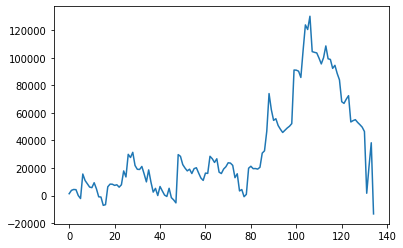

In [53]:
env = TradingEnv(test_input_source, test_to_predict,
                 winlen=winlen, bars_per_episode=3000, traded_amt=traded_amt,
                 commission=commission, slippage=slippage,
                 reward_type='cur_balance',
                 min_ratio_trades = 20,
                 max_position_time = 30,
                 )
env = DummyVecEnv([lambda: env])


nstate = model.initial_state  # get the initial state vector for the reccurent network
#dones = np.zeros(nstate.shape[0])  # set all environment to not done
#nstate=None

observation = env.envs[0].reset()#env.reset()
done = False
navs = []
acts = []
for i in tqdm(range(env.envs[0].bars_per_episode)):
    action, nstate = model.predict([observation], state=nstate, deterministic=1)
    acts.append(action)
    observation, reward, done, info = env.envs[0].step(action)#env.step(action)
    if done:
        break
navs = env.envs[0].returns
kl = []
t = 0
for n in navs:
    t = t + n
    kl.append(t)
plot(kl);

In [16]:
len(navs)

251

In [17]:
# calculate the likelihood of success for any given episode
try:
    l = 10000

    krl = []
    p = pb.ProgressBar(max_value=l)
    for i in range(l):
        p.update(i)
        observation = env.envs[0].reset()
        nstate = model.initial_state
        done = False
        navs = []
        for i in (range(env.envs[0].bars_per_episode)):
            action, nstate = model.predict([observation], state=nstate, deterministic=1)
            acts.append(action)
            observation, reward, done, info = env.envs[0].step(action)#env.step(action)
            if done:
                break
        krl.append(sum(env.envs[0].returns ))
    p.finish()
except KeyboardInterrupt:
    pass

krl = np.array(krl)
print('Profit likelihood: %3.3f%%' % (100*(sum(krl > 0) / len(krl))))

  0% (58 of 10000) |                     | Elapsed Time: 0:00:24 ETA:   1:38:08

Profit likelihood: 3.390%


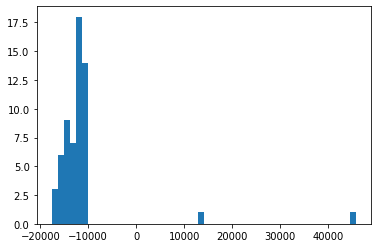

In [18]:
hist(krl,50);

In [19]:
sum(env.envs[0].returns)

5899.999999999977